##1. Download the dataset and import the relevant packages

In [1]:
import os
if not os.path.exists('GTSRB'):
  %pip install -U -q torch_snippets
  !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
  !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
  !unzip -qq GTSRB_Final_Training_Images.zip
  !unzip -qq GTSRB_Final_Test_Images.zip
  !wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
  !rm GTSRB_Final_Training_Images.zip GTSRB_Final_Test_Images.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 97.4 MB/s eta 0:00:00
--2024-10-07 17:39:49--  https://raw.githubusercontent.com/georgesung/traffic_sign_cla

##2.Assign the class Ids to possible output classes

In [2]:
from torch_snippets import *
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix, (k,v) in enumerate(classIds.items())}

##3.Define the transformation pipeline on top of the images without any augmentation

In [3]:
from torchvision import transforms as T


trn_tfms = T.Compose([
  T.ToPILImage(),
  T.Resize(32),
  T.CenterCrop(32),
  # T.ColorJitter(brightness=(0.8, 1.2),
  #               contrast=(0.8, 1.2),
  #               saturation=(0.8, 1.2),
  #               hue=0.25),
  # T.RandomAffine(5, translate=(0.01, 0.1)),
  T.ToTensor(),
  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_tfms = T.Compose([
  T.ToPILImage(),
  T.Resize(32),
  T.CenterCrop(32),
  T.ToTensor(),
  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Define the dataset class -GTSRB

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class GTSRB(Dataset):
  def __init__(self, files, transform=None):
    self.files = files
    self.transform = transform
    logger.info(len(self))

  def __len__(self):
    return len(self.files)

  def __getitem__(self, ix):
    try:
      fpath = self.files[ix]
      clss = fname(parent(fpath))
      img = read(fpath, 1)
      return img, classIds[clss]
    except:
      Warn(f"Missing {fpath}. Loading a different image")
      return self[randint(len(self))]

  def choose(self):
    return self[randint(len(self))]

  def collate_fn(self, batch):
    imgs, classes = list(zip(*batch))
    if self.transform:
      imgs = [self.transform(img)[None] for img in imgs]

    classes = [torch.tensor([id2int[clss]]) for clss in classes]
    imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
    return imgs, classes

##5. Create the training and validation datasets and dataloaders

In [5]:
all_files = Glob('GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)

trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

[10/07/24 17:40:00] INFO     29406                                                                                                 ]8;id=644334;file://<ipython-input-4-3c3c1a2e336f>:9\<ipython-input-4-3c3c1a2e336f>]8;;\:]8;id=270284;file://<ipython-input-4-3c3c1a2e336f>:9#__init__:9\__init__:9]8;;\

                    INFO     9803                                                                                                  ]8;id=20956;file://<ipython-input-4-3c3c1a2e336f>:9\<ipython-input-4-3c3c1a2e336f>]8;;\:]8;id=573439;file://<ipython-input-4-3c3c1a2e336f>:9#__init__:9\__init__:9]8;;\

##6.Define the model -SignClassifier

In [6]:
import torch
import torchvision.models as models
import torch.nn as nn

def convBlock(ni, no):
  return nn.Sequential(
    nn.Dropout(0.2),
    nn.Conv2d(ni, no, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    #nn.BatchNorm2d(no),
    nn.MaxPool2d(2),
  )


class SignClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      convBlock(3, 64),
      convBlock(64, 64),
      convBlock(64, 128),
      convBlock(128, 64),
      nn.Flatten(),
      nn.Linear(256, 256),
      nn.Dropout(0.2),
      nn.ReLU(inplace=True),
      nn.Linear(256, len(id2int))
    )
    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self, x):
    return self.model(x)

  def compute_metrics(self, preds, targets):
    ce_loss = self.loss_fn(preds, targets)
    acc  = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc



##7.Define the functions to train and validate on a batch of data, respectively

In [7]:
def train_batch(model, data, optimizer, criterion):
  ims, labels = data
  _preds = model(ims)
  optimizer.zero_grad()
  loss, acc = criterion(_preds, labels)
  loss.backward()
  optimizer.step()
  return loss.item(), acc.item()


@torch.no_grad()
def validate_batch(model, data, criterion):
  ims, labels = data
  _preds = model(ims)
  loss, acc = criterion(_preds, labels)
  return loss.item(), acc.item()



##8. Define the model and train it over increaseing epochs

In [8]:
dumpy = torch.rand(size=(3, 64, 64))
dumpy


tensor([[[0.1007, 0.6073, 0.1156,  ..., 0.2930, 0.1731, 0.5485],
         [0.1663, 0.1496, 0.0689,  ..., 0.2600, 0.2195, 0.7315],
         [0.7799, 0.3937, 0.4513,  ..., 0.0982, 0.1297, 0.9320],
         ...,
         [0.6259, 0.1598, 0.2367,  ..., 0.7311, 0.0774, 0.1058],
         [0.1076, 0.9467, 0.1076,  ..., 0.7913, 0.5694, 0.3182],
         [0.0582, 0.8418, 0.0096,  ..., 0.1962, 0.3945, 0.4425]],

        [[0.2741, 0.5073, 0.4038,  ..., 0.8582, 0.5790, 0.1613],
         [0.3466, 0.4200, 0.1689,  ..., 0.7679, 0.4722, 0.9672],
         [0.8862, 0.0180, 0.8082,  ..., 0.7290, 0.9975, 0.2601],
         ...,
         [0.7953, 0.0127, 0.2694,  ..., 0.3965, 0.3255, 0.8617],
         [0.8145, 0.8143, 0.4434,  ..., 0.3557, 0.7789, 0.0193],
         [0.2042, 0.6498, 0.1816,  ..., 0.2290, 0.1487, 0.8436]],

        [[0.2733, 0.6527, 0.4172,  ..., 0.1954, 0.2613, 0.4153],
         [0.3746, 0.4824, 0.6811,  ..., 0.3264, 0.2977, 0.9691],
         [0.7635, 0.3131, 0.0745,  ..., 0.0116, 0.7933, 0.

EPOCH: 1.000  trn_acc: 0.300  trn_loss: 2.389  val_loss: 1.542  val_acc: 0.501  (33.57s - 1309.39s remaining)
EPOCH: 2.000  trn_acc: 0.651  trn_loss: 1.067  val_loss: 0.819  val_acc: 0.738  (58.08s - 1103.57s remaining)
EPOCH: 3.000  trn_acc: 0.771  trn_loss: 0.702  val_loss: 0.613  val_acc: 0.797  (84.73s - 1045.01s remaining)
EPOCH: 4.000  trn_acc: 0.817  trn_loss: 0.560  val_loss: 0.515  val_acc: 0.833  (109.02s - 981.15s remaining)
EPOCH: 5.000  trn_acc: 0.841  trn_loss: 0.485  val_loss: 0.463  val_acc: 0.852  (133.96s - 937.71s remaining)
EPOCH: 6.000  trn_acc: 0.858  trn_loss: 0.433  val_loss: 0.435  val_acc: 0.858  (158.91s - 900.52s remaining)
EPOCH: 7.000  trn_acc: 0.869  trn_loss: 0.398  val_loss: 0.394  val_acc: 0.871  (183.87s - 866.80s remaining)
EPOCH: 8.000  trn_acc: 0.879  trn_loss: 0.370  val_loss: 0.419  val_acc: 0.868  (209.34s - 837.34s remaining)
EPOCH: 9.000  trn_acc: 0.885  trn_loss: 0.350  val_loss: 0.366  val_acc: 0.882  (234.74s - 808.54s remaining)
EPOCH: 10.

100%|██████████| 141/141 [00:03<00:00, 45.06it/s]


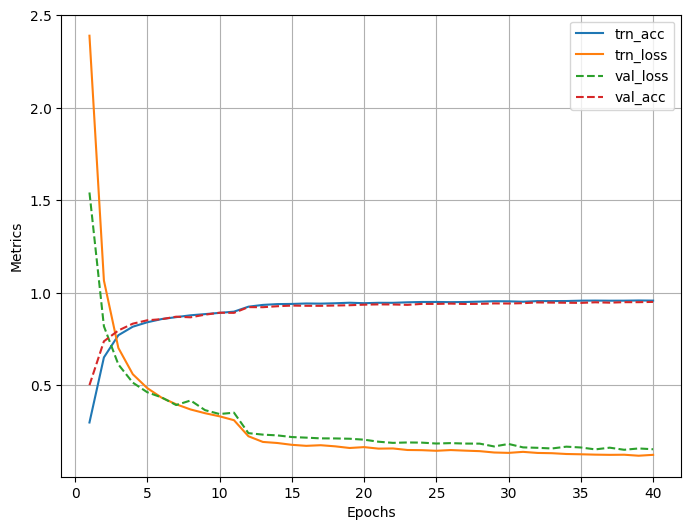

[10/07/24 17:57:18] INFO     Dumped object of size ≈2 MB @ "no-aug-no-bn.log" in 1.63e+00 seconds                          ]8;id=986284;file://<ipython-input-9-976040377a11>:24\<ipython-input-9-976040377a11>]8;;\:<cell line: 24>:24

» no-aug-no-bn.log

In [9]:
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

from torch_snippets.torch_loader import Report
#model(dumpy)
log = Report(n_epochs)
for ex in range(n_epochs):
  N = len(trn_dl)
  for bx, data in enumerate(trn_dl):
    loss, acc = train_batch(model, data, optimizer, criterion)
    log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

  N = len(val_dl)
  for bx, data in enumerate(val_dl):
    loss, acc = validate_batch(model, data, criterion)
    log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

  log.report_avgs(ex+1)
  if ex == 10: optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-no-bn.log')

## Training the model without Augmentation but with Batch-Normalization

In [10]:
# Adding batch normalization
import torch.nn  as nn


def convBlock2(ni, no):
  return nn.Sequential(
    nn.Dropout(0.2),
    nn.Conv2d(ni, no, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(no),
    nn.MaxPool2d(2),
  )


class SignClassifier2(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      convBlock2(3, 64),
      convBlock2(64, 64),
      convBlock2(64, 128),
      convBlock2(128, 64),
      nn.Flatten(),
      nn.Linear(256, 256),
      nn.Dropout(0.2),
      nn.ReLU(inplace=True),
      nn.Linear(256, len(id2int))
    )

    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self, x):
    return self.model(x)

  def compute_metrics(self, preds, targets):
    ce_loss = self.loss_fn(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc



##Training the SignClassifier2

EPOCH: 1.000  trn_acc: 0.023  trn_loss: 3.863  val_loss: 3.866  val_acc: 0.021  (26.02s - 1014.89s remaining)
EPOCH: 2.000  trn_acc: 0.023  trn_loss: 3.862  val_loss: 3.866  val_acc: 0.021  (51.61s - 980.60s remaining)
EPOCH: 3.000  trn_acc: 0.022  trn_loss: 3.862  val_loss: 3.861  val_acc: 0.022  (77.30s - 953.32s remaining)
EPOCH: 4.000  trn_acc: 0.022  trn_loss: 3.865  val_loss: 3.863  val_acc: 0.023  (103.69s - 933.23s remaining)
EPOCH: 5.000  trn_acc: 0.023  trn_loss: 3.862  val_loss: 3.867  val_acc: 0.024  (129.66s - 907.61s remaining)
EPOCH: 6.000  trn_acc: 0.024  trn_loss: 3.862  val_loss: 3.863  val_acc: 0.024  (155.67s - 882.13s remaining)
EPOCH: 7.000  trn_acc: 0.021  trn_loss: 3.862  val_loss: 3.861  val_acc: 0.024  (181.50s - 855.66s remaining)
EPOCH: 8.000  trn_acc: 0.023  trn_loss: 3.862  val_loss: 3.864  val_acc: 0.018  (207.21s - 828.85s remaining)
EPOCH: 9.000  trn_acc: 0.023  trn_loss: 3.862  val_loss: 3.863  val_acc: 0.024  (232.77s - 801.77s remaining)
EPOCH: 10.00

100%|██████████| 141/141 [00:03<00:00, 44.91it/s]


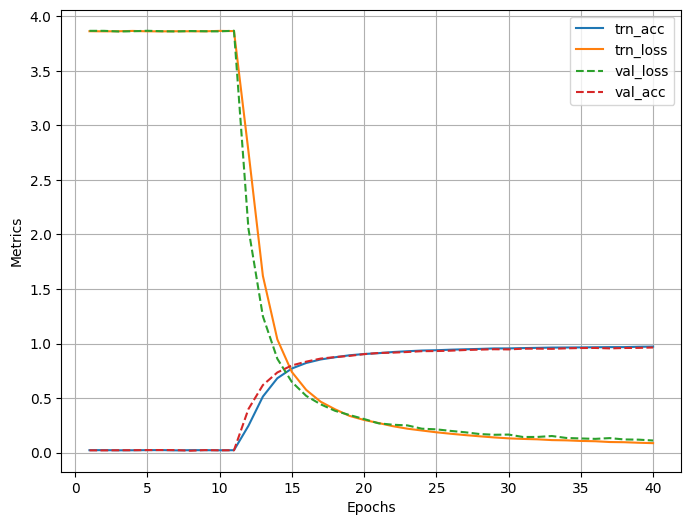

[10/07/24 18:14:39] INFO     Dumped object of size ≈2 MB @ "no-aug-yes-bn.log" in 1.83e+00 seconds                        ]8;id=166868;file://<ipython-input-11-8ae17f5501cd>:23\<ipython-input-11-8ae17f5501cd>]8;;\:<cell line: 23>:23

» no-aug-yes-bn.log

In [11]:
from torch_snippets.torch_loader import Report

model2 = SignClassifier2().to(device)
criterion = model2.compute_metrics

log =Report(n_epochs)
for ex in range(n_epochs):
  N = len(trn_dl)

  for bx, data in enumerate(trn_dl):
    loss, acc  =train_batch(model2, data, optimizer, criterion)
    log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

  N = len(val_dl)
  for bx, data in enumerate(val_dl):
    loss, acc =   validate_batch(model2, data, criterion)
    log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='r')

  log.report_avgs(ex+1)
  if ex == 10: optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-yes-bn.log')

##Training model with  Augmentation and Batch-Normalization

In [ ]:
# Changing the transform for the train set to have augmentation

trn_tfms2 = T.Compose([
  T.ToPILImage(),
  T.Resize(32),
  T.CenterCrop(32),
  T.ColorJitter(brightness=(0.8, 1.2),
                contrast=(0.8, 1.2),
                saturation=(0.8, 1.2),
                hue=0.25),
  T.RandomAffine(5, translate=(0.01, 0.1)),
  T.ToTensor(),
  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trn_ds2 = GTSRB(trn_files, transform=trn_tfms2)
trn_dl2 = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds2.collate_fn)

[10/07/24 18:18:01] INFO     29406                                                                                                 ]8;id=600823;file://<ipython-input-4-3c3c1a2e336f>:9\<ipython-input-4-3c3c1a2e336f>]8;;\:]8;id=363787;file://<ipython-input-4-3c3c1a2e336f>:9#__init__:9\__init__:9]8;;\

## Training the SignClassifer2 model with both data augmentation and Batch-Normalization.

EPOCH: 1.000  trn_acc: 0.018  trn_loss: 3.871  val_loss: 3.870  val_acc: 0.019  (47.74s - 1861.87s remaining)
EPOCH: 2.000  trn_acc: 0.019  trn_loss: 3.870  val_loss: 3.876  val_acc: 0.015  (94.59s - 1797.23s remaining)
EPOCH: 3.000  trn_acc: 0.020  trn_loss: 3.869  val_loss: 3.872  val_acc: 0.019  (143.14s - 1765.37s remaining)
EPOCH: 4.000  trn_acc: 0.018  trn_loss: 3.872  val_loss: 3.874  val_acc: 0.018  (189.53s - 1705.80s remaining)
EPOCH: 5.000  trn_acc: 0.018  trn_loss: 3.872  val_loss: 3.875  val_acc: 0.018  (235.53s - 1648.70s remaining)
EPOCH: 6.000  trn_acc: 0.018  trn_loss: 3.868  val_loss: 3.871  val_acc: 0.016  (282.11s - 1598.61s remaining)
EPOCH: 7.000  trn_acc: 0.018  trn_loss: 3.868  val_loss: 3.875  val_acc: 0.016  (328.37s - 1548.04s remaining)
EPOCH: 8.000  trn_acc: 0.019  trn_loss: 3.868  val_loss: 3.876  val_acc: 0.017  (374.03s - 1496.11s remaining)
EPOCH: 9.000  trn_acc: 0.019  trn_loss: 3.872  val_loss: 3.878  val_acc: 0.018  (420.76s - 1449.27s remaining)
EPO

100%|██████████| 141/141 [00:03<00:00, 46.93it/s]


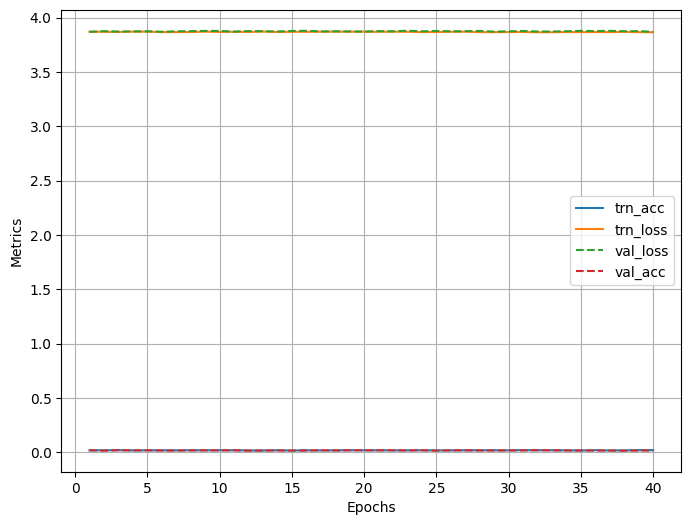

[10/07/24 18:49:37] INFO     Dumped object of size ≈2 MB @ "40-yes-aug-yes-bn.log" in 1.64e+00 seconds                    ]8;id=860152;file://<ipython-input-17-ba35b1218c79>:20\<ipython-input-17-ba35b1218c79>]8;;\:<cell line: 20>:20

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
model3 = SignClassifier2().to(device)
criterion = model3.compute_metrics

log = Report(n_epochs)
for ex in range(n_epochs):
  N = len(trn_dl2)
  for bx, data in enumerate(trn_dl2):
    loss, acc = train_batch(model3, data, optimizer, criterion)
    log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

  N = len(val_dl)
  for bx, data in enumerate(val_dl):
    loss, acc = validate_batch(model3, data, criterion)
    log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

  log.report_avgs(ex+1)
  if ex == 10: optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, '40-yes-aug-yes-bn.log')
from google.colab import files
files.download('40-yes-aug-yes-bn.log')


## Visualize the results


EPOCH: 20.000  trn_acc: 0.904  trn_loss: 0.300  val_loss: 0.308  val_acc: 0.903  (3200.87s - 3200.87s remaining)


100%|██████████| 141/141 [00:02<00:00, 58.13it/s] 


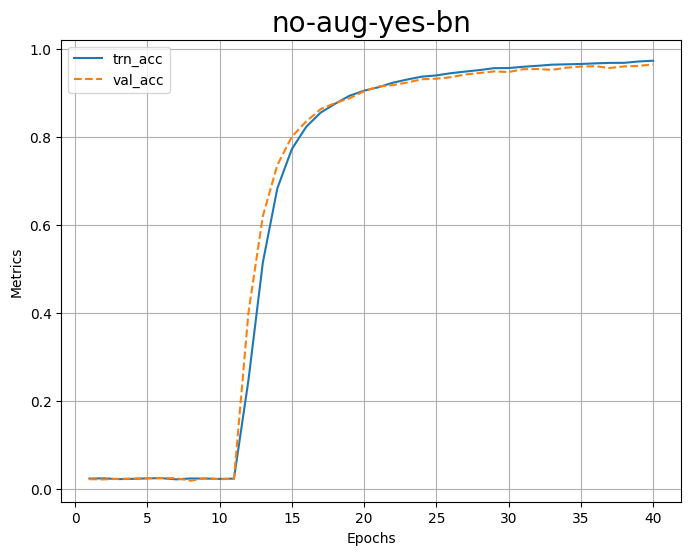


══════════════════════════════════════════════════════════════════

EPOCH: 20.000  trn_acc: 0.944  trn_loss: 0.167  val_loss: 0.207  val_acc: 0.936  (4241.33s - 4241.33s remaining)


100%|██████████| 141/141 [00:01<00:00, 90.00it/s] 


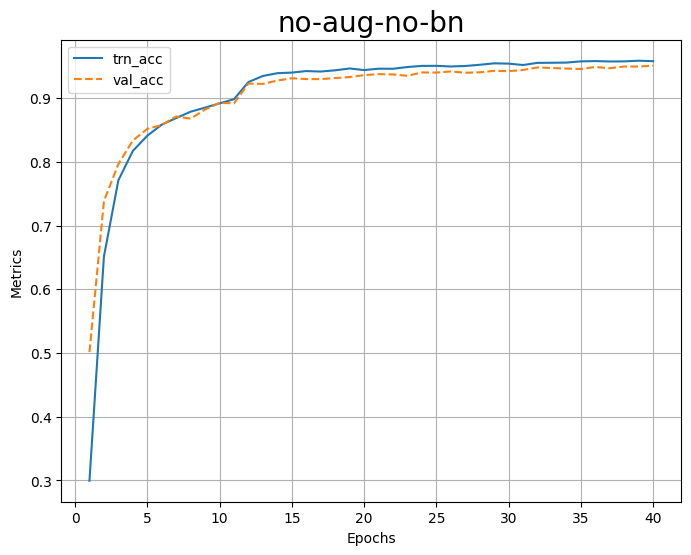


══════════════════════════════════════════════════════════════════

EPOCH: 20.000  trn_acc: 0.019  trn_loss: 3.871  val_loss: 3.872  val_acc: 0.019  (1905.67s - 1905.67s remaining)


100%|██████████| 141/141 [00:01<00:00, 118.79it/s]


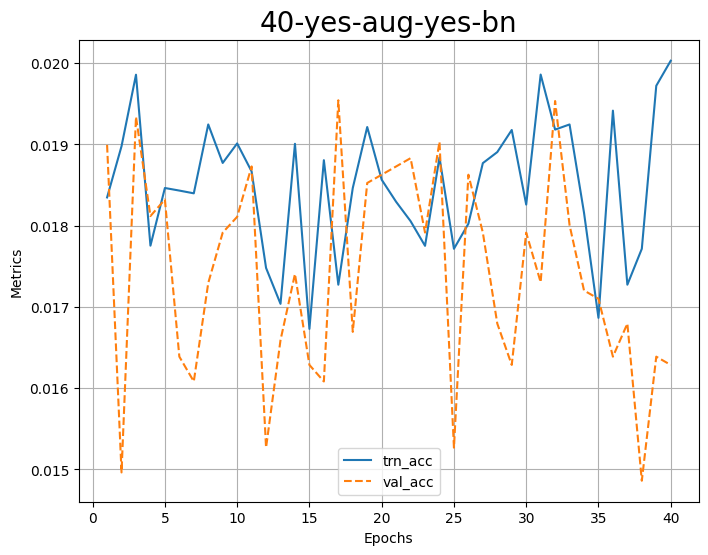


══════════════════════════════════════════════════════════════════


In [18]:
for f in Glob('*.log'):
  log = loaddill(f)
  print()
  log.report_avgs(20)
  log.plot_epochs(['trn_acc', 'val_acc'], title=str(f).replace(',','\n').replace('.log', ''))
  print()
  line()